Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.


Compiling model...
Building feed-forward neural network...
'build' took 0.029066 s



C:\Users\npofsi\AppData\Roaming\Python\Python39\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\npofsi\AppData\Roaming\Python\Python39\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.872133 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                                                  Test loss                                                                                                                                                                                                   Test metric
0         [8.20e+00, 4.04e+00, 3.13e+01, 9.89e+00, 5.05e-02, 9.44e-03, 4.86e-01, 5.43e-04, 2.10e-01, 4.25e-02, 8.24e-03, 2.33e-03, 5.13e-01, 1.15e-01, 6.07e-01, 2.89e-01, 2.77e-01, 1.52e-01, 7.78e-01, 2.68e-01]    [8.23e+00, 4.06e+00, 3.15e+01, 9.93e+00, 5.05e-02, 9.44e-03, 4.86e-01, 5.43e-04, 2.10e-01, 4.25e-02, 8.24e-03, 2.33e-03, 5.13e-01, 1.15e-01, 6.07e-01, 2.89e-01, 2.77e-01, 1.52e-01, 7.78e-01, 2.68e-01]    []  
1000      [5.99e-04, 9.36e-04, 1.32e-03, 1.48e-03, 2.30e-05, 1.73e-05, 5.38

19000     [1.46e-03, 1.41e-03, 4.27e-03, 4.60e-03, 4.41e-06, 1.85e-06, 1.72e-06, 2.09e-06, 1.15e-05, 1.25e-06, 5.38e-06, 1.87e-06, 3.11e-04, 3.46e-04, 6.65e-04, 5.43e-04, 4.47e-03, 5.00e-03, 1.67e-02, 1.72e-02]    [1.43e-03, 1.39e-03, 4.21e-03, 4.60e-03, 4.41e-06, 1.85e-06, 1.72e-06, 2.09e-06, 1.15e-05, 1.25e-06, 5.38e-06, 1.87e-06, 3.11e-04, 3.46e-04, 6.65e-04, 5.43e-04, 4.47e-03, 5.00e-03, 1.67e-02, 1.72e-02]    []  
20000     [1.51e-03, 1.43e-03, 4.19e-03, 4.55e-03, 2.41e-06, 1.75e-06, 2.38e-06, 2.24e-06, 6.18e-06, 1.20e-06, 3.25e-06, 2.11e-06, 3.02e-04, 3.28e-04, 6.49e-04, 5.07e-04, 4.46e-03, 4.87e-03, 1.63e-02, 1.68e-02]    [1.48e-03, 1.41e-03, 4.14e-03, 4.54e-03, 2.41e-06, 1.75e-06, 2.38e-06, 2.24e-06, 6.18e-06, 1.20e-06, 3.25e-06, 2.11e-06, 3.02e-04, 3.28e-04, 6.49e-04, 5.07e-04, 4.46e-03, 4.87e-03, 1.63e-02, 1.68e-02]    []  

Best model at step 20000:
  train loss: 5.59e-02
  test loss: 5.58e-02
  test metric: []

'train' took 2201.925295 s

Saving loss history to C:\Users\npo

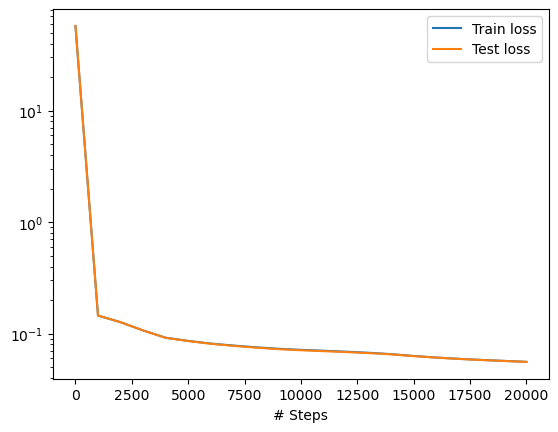

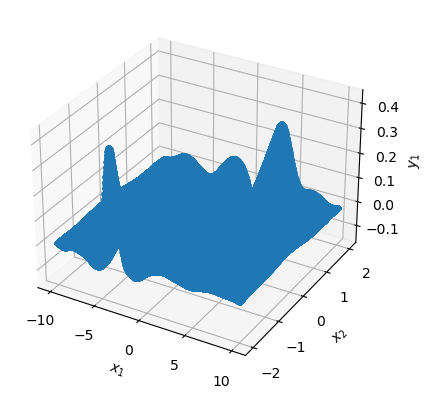

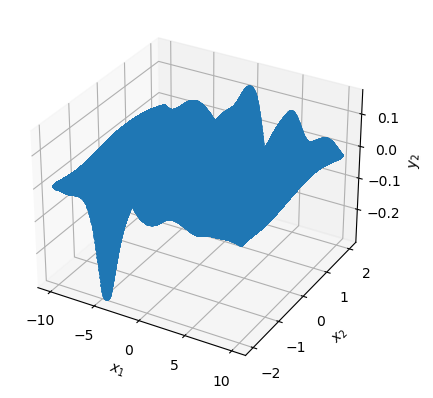

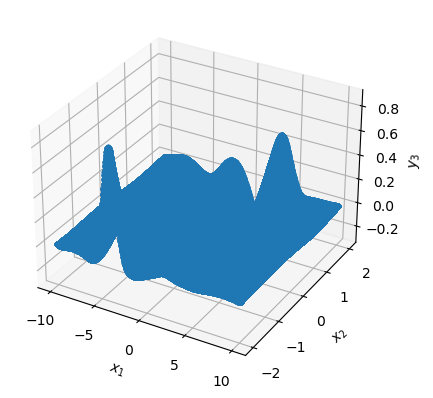

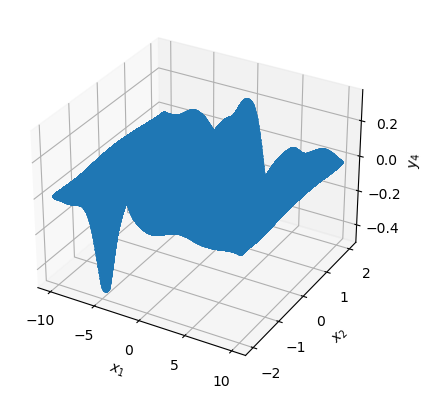

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
a = 1
b = 2
k_r = 1.5
k_i = 1
v_1 = 1
v_2 = 1
v_3 = 1
c=0
def gen_traindata():

    x_lower = -10
    x_upper = 10
    t_lower = -2
    t_upper = 2

    x = np.linspace(x_lower, x_upper, 401)
    t = np.linspace(t_lower, t_upper, 401)
    X, T = np.meshgrid(x, t)
    X = np.reshape(X, (-1, 1))
    T = np.reshape(T, (-1, 1))
#     X=np.linspace(x_lower,x_upper,200)
#     X=np.tile(X,200)
#     X=X[:,np.newaxis]
#     T=np.linspace(t_lower,t_upper,200)
#     T=np.repeat(T,200)
#     T=T[:,np.newaxis]
    c = np.log((a * a * v_1 + b * b * v_2 + a * b * v_3 + a * b * v_3) / ((2 * k_r) * (2 * k_r)))
    u1 = (a / 2) * np.exp(-c / 2) * np.cos(k_i*X + (k_r*k_r-k_i*k_i) * T) / np.cosh(k_r* X - 2*k_r*k_i * T + c / 2)
    v1 = (a / 2) * np.exp(-c / 2) * np.sin(k_i*X + (k_r*k_r-k_i*k_i) * T) / np.cosh(k_r* X - 2*k_r*k_i * T + c / 2)
    u2 = (b / 2) * np.exp(-c / 2) * np.cos(k_i*X + (k_r*k_r-k_i*k_i) * T) / np.cosh(k_r* X - 2*k_r*k_i * T + c / 2)
    v2 = (b / 2) * np.exp(-c / 2) * np.sin(k_i*X + (k_r*k_r-k_i*k_i) * T) / np.cosh(k_r* X - 2*k_r*k_i * T + c / 2)

   
    U1=np.reshape(u1,(-1,1))
    V1=np.reshape(v1,(-1,1))
    U2=np.reshape(u2,(-1,1))
    V2=np.reshape(v2,(-1,1))
    
    return np.hstack((X, T)), U1,V1,U2,V2


#kf = dde.Variable(0.05)
#D = dde.Variable(1.0)
m0=dde.Variable(1.5)
m1=dde.Variable(3.0)
m2=dde.Variable(2.0)
m3=dde.Variable(1.0)

def pde(x,y):
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    f_u1 = (
            v1_t + u1_xx
            + 2 * u1 * (m0 * (u1 ** 2 + v1 ** 2) + m1 * (u2 ** 2 + v2 ** 2) + (m2 + m3) * (u1 * u2 + v1 * v2))
           +2*v1*(m2-m3)*(u1*v2-v1*u2)
    )

    f_v1 = (
            u1_t - v1_xx
            - 2 * v1 * (m0 * (u1 ** 2 + v1 ** 2) + m1 * (u2 ** 2 + v2 ** 2) + (m2 + m3) * (u1 * u2 + v1 * v2))
           +2*u1*(m2-m3)*(u1*v2-v1*u2)
    )
    
    f_u2 = (
            v2_t + u2_xx
            + 2 * u2 * (m0 * (u1 ** 2 + v1 ** 2) + m1 * (u2 ** 2 + v2 ** 2) + (m2 + m3) * (u1 * u2 + v1 * v2))
           +2*v2*(m2-m3)*(u1*v2-v1*u2)
    )

    f_v2 = (
           u2_t - v2_xx
            - 2 * v2 * (m0 * (u1 ** 2 + v1 ** 2) + m1 * (u2 ** 2 + v2 ** 2) + (m2 + m3) * (u1 * u2 + v1 * v2))
           +2*u2*(m2-m3)*(u1*v2-v1*u2)
    )
    
    return [f_u1, f_v1,f_u2,f_v2]


def fun_bc(x):
    return x[:, 0:1]


#def fun_init(x):
#    return np.exp(-20 * x[:, 0:1])

# def init_cond_u1(x):
#     return (a/2) * np.cos(x[:, 0:1]) * np.exp(-c/2) / np.cosh(1.5*x[:, 0:1]+(c/2))
# def init_cond_u2(x):
#     return (b/2)*np.cos(x[:, 0:1]) * np.exp(-c/2) / np.cosh(1.5*x[:, 0:1]+(c/2))

# def init_cond_v1(x):
#     return (-a/2) * np.sin(x[:, 0:1]) * np.exp(-c/2) / np.cosh(1.5*x[:, 0:1]+(c/2))
# def init_cond_v2(x):
#     return (-b/2)*np.sin(x[:, 0:1]) * np.exp(-c/2) / np.cosh(1.5*x[:, 0:1]+(c/2))

def sech(x):
    return 1/(np.cosh(x))

def init_cond_u1(x):
    return 0.5*sech(1.5*x[:,0:1]+6)*np.cos(x[:,0:1]-2.5)

def init_cond_v1(x):
    return 0.5*sech(1.5*x[:,0:1]+6)*np.sin(x[:,0:1]-2.5)

def init_cond_u2(x):
    return sech(1.5*x[:,0:1]+6)*np.cos(x[:,0:1]-2.5)

def init_cond_v2(x):
    return sech(1.5*x[:,0:1]+6)*np.sin(x[:,0:1]-2.5)


#geom = dde.geometry.Interval(0, 1)
#timedomain = dde.geometry.TimeDomain(0, 10)
#geomtime = dde.geometry.GeometryXTime(geom, timedomain)

x_lower = -10
x_upper = 10
t_lower = -2
t_upper = 2

# 创建 2D 域（用于绘图和输入）


# 整个域变平
#X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
geom = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(geom, time_domain)




# bc_u1_0 = dde.icbc.DirichletBC(
#     geomtime,fun_bc, lambda _, on_boundary: on_boundary, component=0
# )
# bc_u1_1 = dde.icbc.DirichletBC(
#     geomtime, fun_bc, lambda _, on_boundary: on_boundary,  component=0
# )
# bc_v1_0 = dde.icbc.DirichletBC(
#     geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=1
# )
# bc_v1_1 = dde.icbc.DirichletBC(
#     geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=1
# )
# bc_u2_0 = dde.icbc.DirichletBC(
#     geomtime,fun_bc, lambda _, on_boundary: on_boundary,  component=2
# )
# bc_u2_1 = dde.icbc.DirichletBC(
#     geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=2
# )
# bc_v2_0 = dde.icbc.DirichletBC(
#     geomtime,fun_bc, lambda _, on_boundary: on_boundary,component=3
# )
# bc_v2_1 = dde.icbc.DirichletBC(
#     geomtime, fun_bc, lambda _, on_boundary: on_boundary,  component=3
# )

bc_u1_0=dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_v1_0=dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_u2_0=dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_v2_0=dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_u1_1=dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_1=dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_1=dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_1=dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
#ic1 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=0)
#ic2 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=1)

ic_u1 = dde.icbc.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.icbc.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.icbc.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.icbc.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)

observe_x, u1,v1,u2,v2 = gen_traindata()
observe_y1 = dde.icbc.PointSetBC(observe_x, u1, component=0)
observe_y2 = dde.icbc.PointSetBC(observe_x, v1, component=1)
observe_y3 = dde.icbc.PointSetBC(observe_x, u2, component=2)
observe_y4 = dde.icbc.PointSetBC(observe_x, v2, component=3)

data = dde.data.TimePDE(
    geomtime,
    pde,
    #[bc_a, bc_b, ic1, ic2, observe_y1, observe_y2],
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2,observe_y1, observe_y2,observe_y3,observe_y4],
    num_domain=40000,
    num_boundary=200,
    num_initial=200,
    anchors=observe_x,
    num_test=50000,
)
net = dde.nn.FNN([2] + [20] * 3 + [4], "sin", "Glorot uniform")



model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[m0,m1,m2,m3])
variable = dde.callbacks.VariableValue([m0,m1,m2,m3], period=1000, filename="variables.dat")
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [2]:
# print(m0)
# print(m1)
# print(m2)
# print(m3)
# np.narray(m0)

In [3]:
# M=[m0,m1,m2,m3]
# import tensorflow as tf
# for i in range(4):
#     with tf.compat.v1.Session() as sess:
#         sess.run(M[i].initializer)
#         print(sess.run(M[i]))

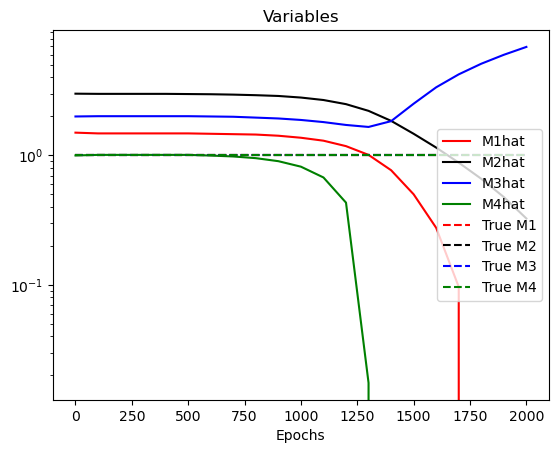

In [4]:
import re
import matplotlib.pyplot as plt
lines = open("variables.dat", "r").readlines()
# read output data in fnamevar
Mhat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Mhat.shape
plt.semilogy(range(0, l * 100, 100), Mhat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Mhat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), Mhat[:, 2], "b-")
plt.semilogy(range(0, l * 100, 100), Mhat[:, 3], "g-")
plt.semilogy(range(0, l * 100, 100), np.ones(Mhat[:, 0].shape) * 1, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Mhat[:, 1].shape) * 1, "k--")
plt.semilogy(range(0, l * 100, 100), np.ones(Mhat[:, 2].shape) * 1, "b--")
plt.semilogy(range(0, l * 100, 100), np.ones(Mhat[:, 3].shape) * 1, "g--")
plt.legend(["M1hat", "M2hat", "M3hat", "M4hat","True M1", "True M2","True M3", "True M4"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()
